In [1]:
import json
import warnings
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay, accuracy_score, confusion_matrix, log_loss,
    precision_score, roc_auc_score, roc_curve,
)
from sklearn.metrics._classification import UndefinedMetricWarning
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm
from sklearn import preprocessing
import warnings
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.express as px

warnings.filterwarnings('ignore')

In [2]:
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('./data/employee_attrition_previous_closure.csv')

In [4]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,50.0,No,Travel_Rarely,1126.0,Research & Development,1.0,2,Medical,1,997,...,3,80,1,32,1,2,5,4,1,3
1,36.0,No,Travel_Rarely,216.0,Research & Development,6.0,2,Medical,1,178,...,4,80,2,7,0,3,3,2,0,1
2,21.0,Yes,Travel_Rarely,337.0,Sales,7.0,1,Marketing,1,1780,...,2,80,0,1,3,3,1,0,1,0
3,50.0,No,Travel_Frequently,1246.0,Human Resources,NaN,3,Medical,1,644,...,3,80,1,32,2,3,32,5,10,7
4,52.0,No,Travel_Rarely,994.0,Research & Development,7.0,4,Life Sciences,1,1118,...,4,80,0,18,4,3,8,6,4,0


## 1. Data Pre-processing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       893 non-null    float64
 1   Attrition                 1029 non-null   object 
 2   BusinessTravel            1024 non-null   object 
 3   DailyRate                 1002 non-null   float64
 4   Department                1029 non-null   object 
 5   DistanceFromHome          934 non-null    float64
 6   Education                 1029 non-null   int64  
 7   EducationField            1029 non-null   object 
 8   EmployeeCount             1029 non-null   int64  
 9   EmployeeNumber            1029 non-null   int64  
 10  EnvironmentSatisfaction   1029 non-null   int64  
 11  Gender                    1029 non-null   object 
 12  HourlyRate                1029 non-null   int64  
 13  JobInvolvement            1029 non-null   int64  
 14  JobLevel

In [6]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,50.0,No,Travel_Rarely,1126.0,Research & Development,1.0,2,Medical,1,997,...,3,80,1,32,1,2,5,4,1,3
1,36.0,No,Travel_Rarely,216.0,Research & Development,6.0,2,Medical,1,178,...,4,80,2,7,0,3,3,2,0,1
2,21.0,Yes,Travel_Rarely,337.0,Sales,7.0,1,Marketing,1,1780,...,2,80,0,1,3,3,1,0,1,0
3,50.0,No,Travel_Frequently,1246.0,Human Resources,NaN,3,Medical,1,644,...,3,80,1,32,2,3,32,5,10,7
4,52.0,No,Travel_Rarely,994.0,Research & Development,7.0,4,Life Sciences,1,1118,...,4,80,0,18,4,3,8,6,4,0


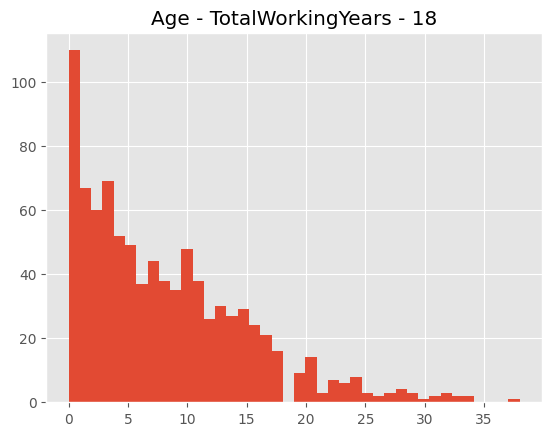

In [7]:
plt.hist(df['Age'] - df['TotalWorkingYears'] - 18, 40)
plt.title('Age - TotalWorkingYears - 18')
plt.show()

Most is 18 -> We can assume everyone starts working at 18. But first let's see if Age is an important variable. If it's important, then we impute, based on the above assumption. If not then drop

In [8]:
df.isna().sum()

Age                         136
Attrition                     0
BusinessTravel                5
DailyRate                    27
Department                    0
DistanceFromHome             95
Education                     0
EducationField                0
EmployeeCount                 0
EmployeeNumber                0
EnvironmentSatisfaction       0
Gender                        0
HourlyRate                    0
JobInvolvement                0
JobLevel                      0
JobRole                       0
JobSatisfaction               0
MaritalStatus                 5
MonthlyIncome                 0
MonthlyRate                   0
NumCompaniesWorked            0
Over18                        0
OverTime                      0
PercentSalaryHike             0
PerformanceRating             0
RelationshipSatisfaction      0
StandardHours                 0
StockOptionLevel              0
TotalWorkingYears             0
TrainingTimesLastYear         0
WorkLifeBalance               0
YearsAtC

In [9]:
# Drop the missing rows for EDA purpose. We reduced the data from 1029 rows to 775 -> around 250 rows have been deleted.
df = df.dropna()
df.shape

(775, 35)

In [10]:
# Check duplication
dups = df.duplicated() #checks each row of the dataset and returns TRUE or FALSE depending on whether it is a duplicate
print(dups.any()) #returns TRUE if there is any value in dups that is equal to TRUE

False


In [11]:
# Check the count of values in each column
df.nunique()

Age                          39
Attrition                     2
BusinessTravel                3
DailyRate                   589
Department                    3
DistanceFromHome             27
Education                     5
EducationField                6
EmployeeCount                 1
EmployeeNumber              775
EnvironmentSatisfaction       4
Gender                        2
HourlyRate                   71
JobInvolvement                4
JobLevel                      5
JobRole                       9
JobSatisfaction               4
MaritalStatus                 3
MonthlyIncome               743
MonthlyRate                 766
NumCompaniesWorked           10
Over18                        1
OverTime                      2
PercentSalaryHike            15
PerformanceRating             2
RelationshipSatisfaction      4
StandardHours                 1
StockOptionLevel              4
TotalWorkingYears            40
TrainingTimesLastYear         7
WorkLifeBalance               4
YearsAtC

In [12]:
# Drop columns that have only one value and the column Employee Number
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1, inplace=True)

## 2. Distribution of Attrition statuses

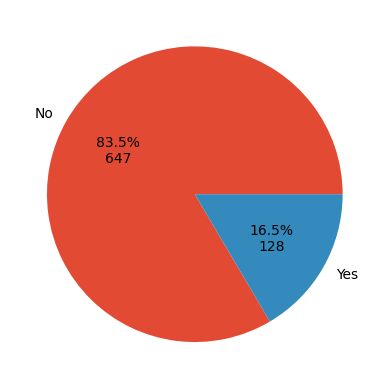

In [13]:
attrition_pct = df['Attrition'].value_counts()

total = attrition_pct.sum()

def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

plt.pie(attrition_pct, labels=attrition_pct.index, autopct=fmt)
plt.show()

In [14]:
# sns.pairplot(df, hue="Attrition")

# Feature distribution

In [15]:
for col in df.drop('Attrition', axis=1).columns:
    sns.displot(df, x=col, hue='Attrition', multiple='dodge', common_norm=False, stat='proportion')
    plt.title(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'./output/feature_distribution/{col}.png')
    plt.close()

# Data transformation

In [16]:
# Check for variables with skew above 0.75
df = df.copy()
skew_limit = 0.75
skew_vals = df.skew()
skew_cols = (
    skew_vals
    .sort_values(ascending=False)
    .to_frame()
    .rename(columns={0:'Skew'})
    .query('abs(Skew) > {}'.format(skew_limit))
)

display(skew_cols.style.set_caption('Columns to be log-transformed:'))

# Log-transform skewed variables
for i in skew_cols.index.values:
    df[i] = df[i].apply(np.log1p)

,Skew
YearsSinceLastPromotion,1.872017
PerformanceRating,1.858451
YearsAtCompany,1.531403
MonthlyIncome,1.218285
NumCompaniesWorked,0.975111
TotalWorkingYears,0.966111
JobLevel,0.926360
StockOptionLevel,0.924670
YearsInCurrentRole,0.893119
DistanceFromHome,0.843194


## 2. Correlation matrix

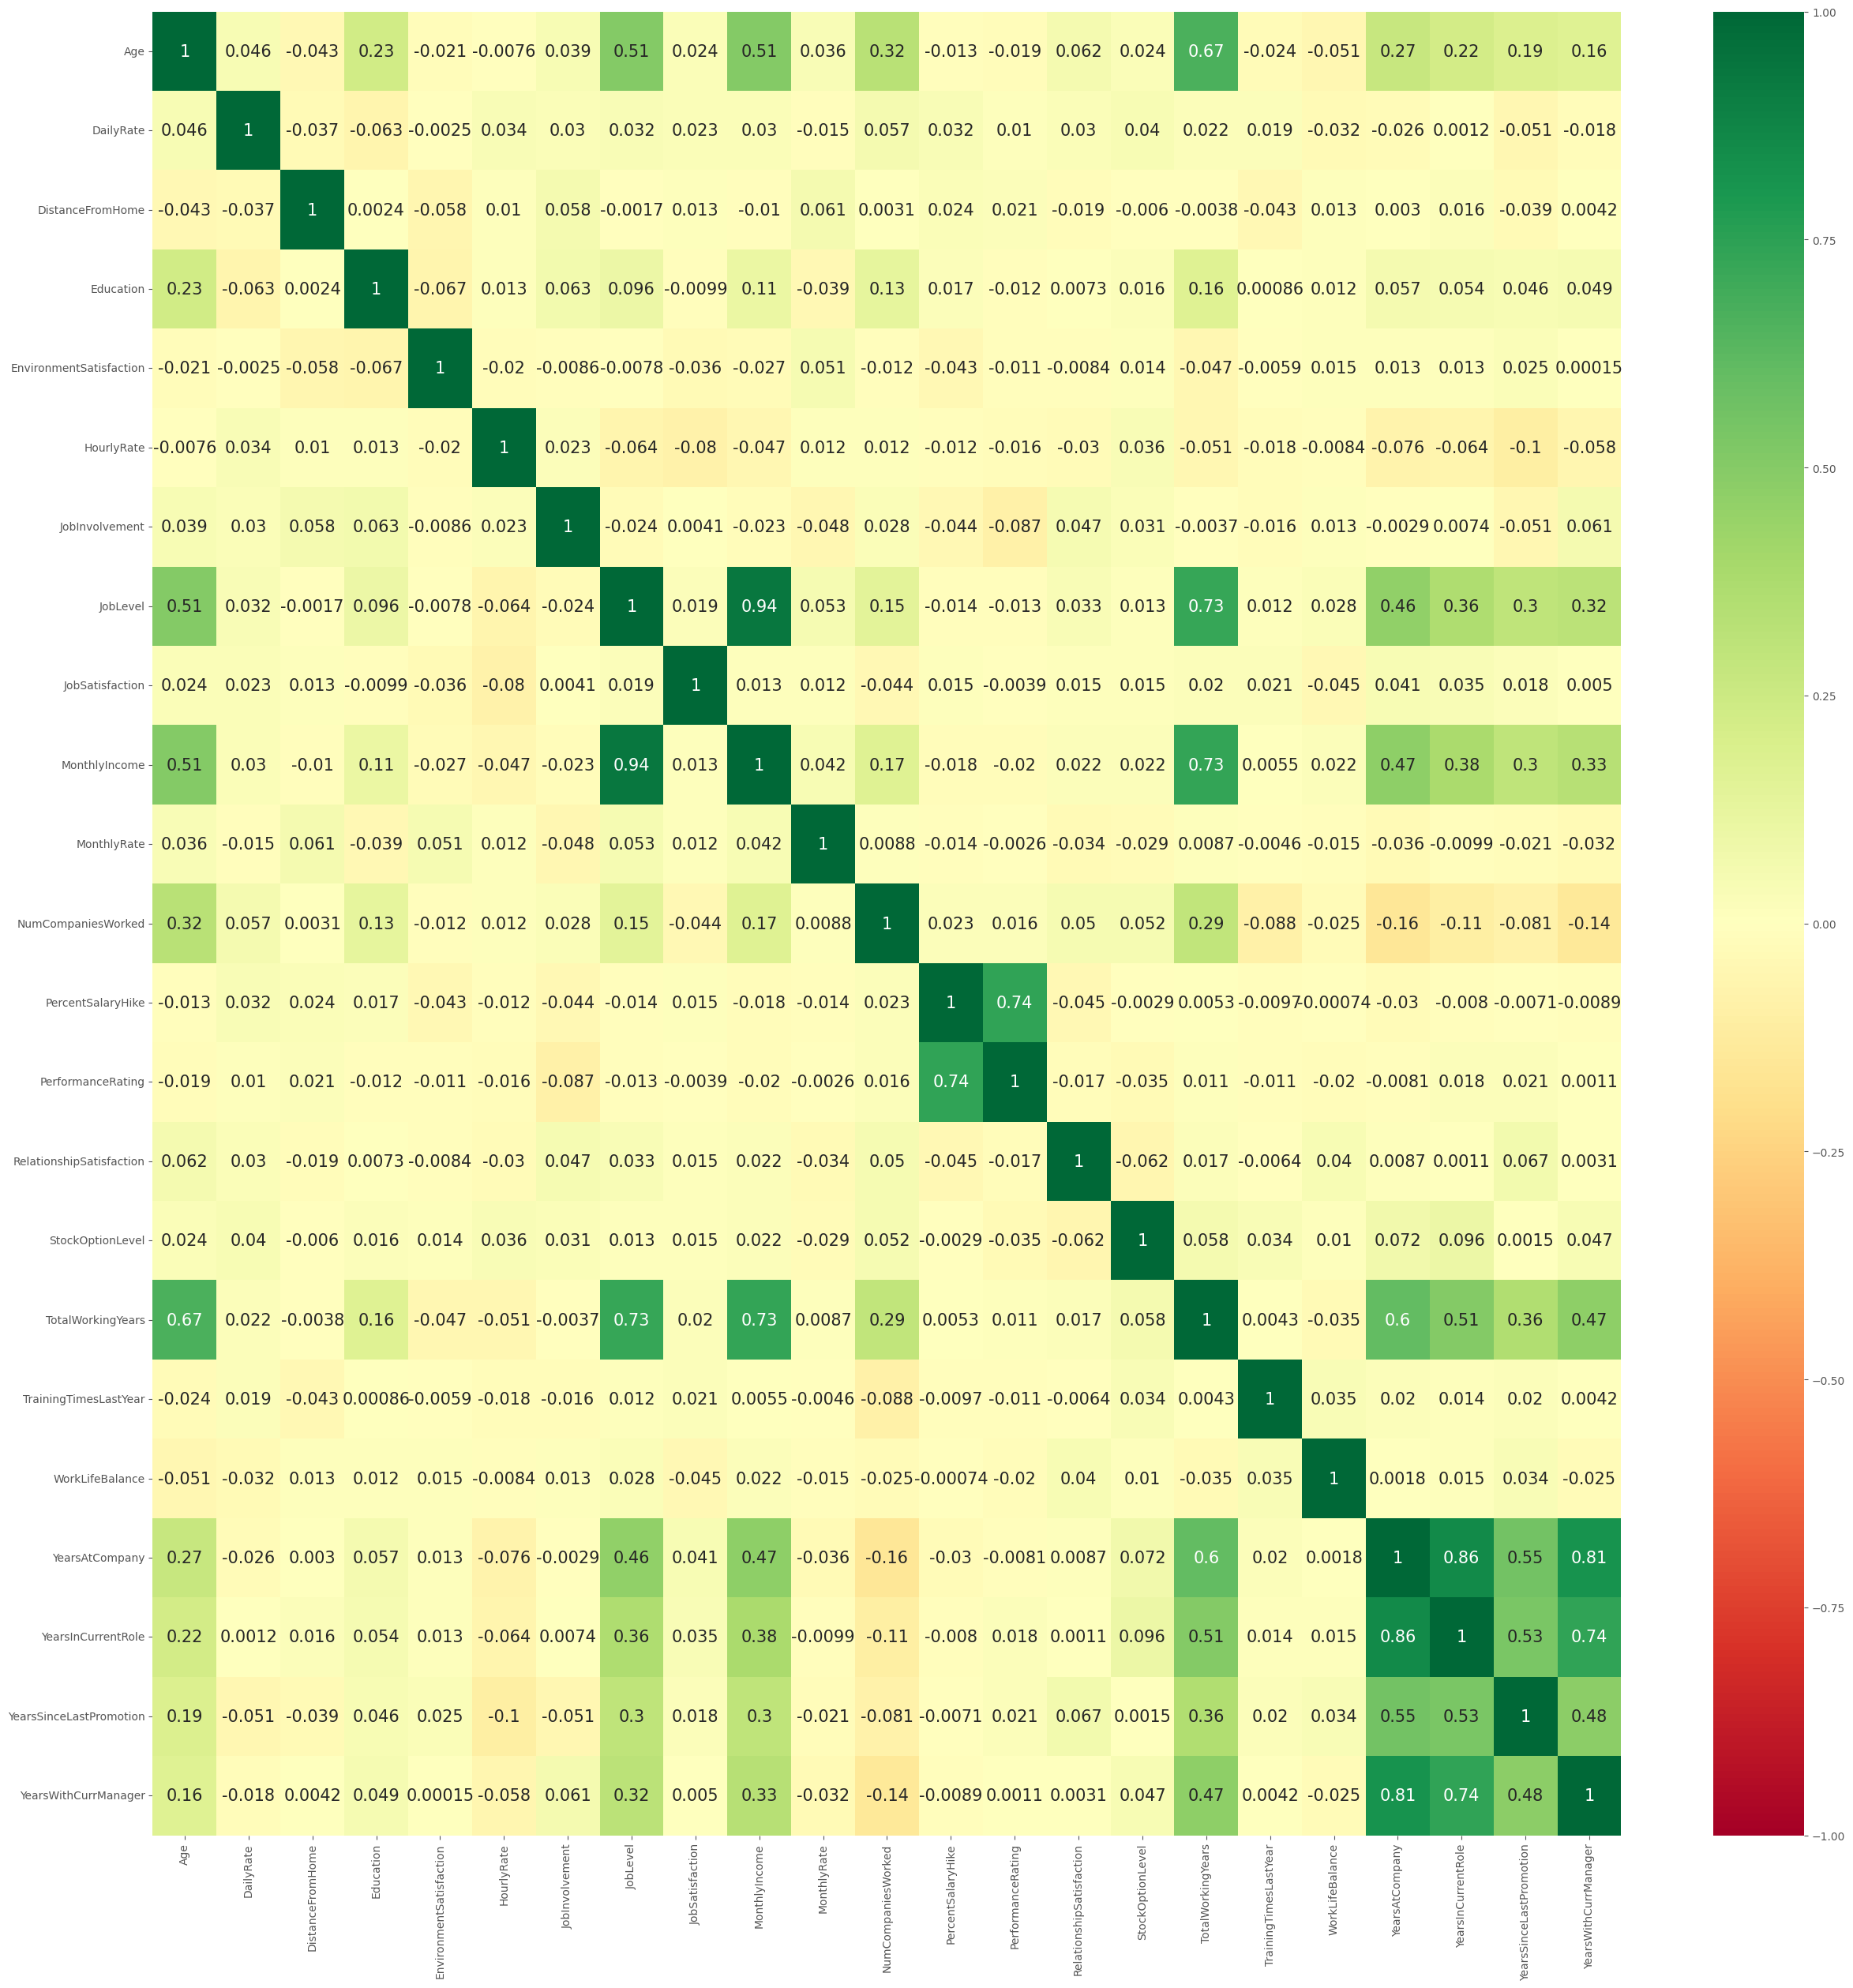

In [18]:
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn", annot_kws={"size":15}, vmin=-1, vmax=1)
plt.show()

High correlations:

- Age & Total working years: 0.68
- Job level & Monthly income: 0.95
- Job level & Total Working years: 0.79
- Monthly income & Total Working years: 0.77
- Percent Salary Hike & Performance Rating: 0.77
- Total Working Years & Years at Company: 0.62
- Years at Company & Years in Current Role: 0.78
- Years at Company & Years since last Promotion: 0.59
- Years At Company & Years with Current Manager: 0.76
- Years in Current Role & Years since Last Promotion: 0.55
- Years in Current Role & Years with Current Manager: 0.71

Looking at the plot:
- Age seems to be an important variable with people leaving more at young age. Let's run a linear model and see if it's significant in predicting attrition. We'll need to impute it
- Distance from home does not seem to be predictive of Attrition, as the distribution of DistanceFromHome for both the attrition and non-attrition group is very similar -> We can drop this column
- DailyRate is missing for a very small proportion of the data and has a very weak correlation with other variables. This means we cannot reliably infer its values.
